### (1) Import basic libs

In [1]:
#basic libs for data processing etc.
import pandas as pd
import numpy as np
import pickle
import time
from datetime import datetime
import random
import gc

#basic libs for data vizualisations
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

#Regressors
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#Eval metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

### (2) Import data from preparation

In [2]:
df = pd.read_pickle('data_prep_final.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933482 entries, 1122795 to 11056276
Data columns (total 26 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int32  
 1   item_id                    int32  
 2   date_block_num             int32  
 3   item_cnt_month             float16
 4   item_category_common       int32  
 5   item_category_code         int32  
 6   weeknd_count               int64  
 7   days_in_month              int64  
 8   item_first_interaction     int8   
 9   shop_item_sold_before      int8   
 10  date_cat_median_item_cnt   float16
 11  item_cnt_month_lag_1       float16
 12  item_cnt_month_lag_2       float16
 13  item_cnt_month_lag_3       float16
 14  item_cnt_month_lag_12      float16
 15  item_shop_price_avg_lag_1  float16
 16  item_shop_price_avg_lag_2  float16
 17  item_shop_price_avg_lag_3  float16
 18  item_target_enc_lag_1      float16
 19  item_target_enc_lag_2      float16


### (3) Split data into train, valid, test

In [3]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
#X_train = df[df.date_block_num < 33].drop(['item_cnt_month', 'item_target_enc_lag_12', 'new_item_cat_avg_lag_12', 'item_cnt_month_lag_12'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
#X_valid = df[df.date_block_num == 33].drop(['item_cnt_month', 'item_target_enc_lag_12', 'new_item_cat_avg_lag_12', 'item_cnt_month_lag_12'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
#X_test = df[df.date_block_num == 34].drop(['item_cnt_month', 'item_target_enc_lag_12', 'new_item_cat_avg_lag_12', 'item_cnt_month_lag_12'], axis=1)
y_test = df[df.date_block_num == 34]['item_cnt_month']
del df
gc.collect()

0

In [4]:
X_test.head()

,shop_id,item_id,date_block_num,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,date_cat_median_item_cnt,...,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_target_enc_lag_12,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_cat_avg_lag_12
10842077,5,5037,34,5,19,5,30,0,1,0.0,...,-0.203979,0.116821,0.568359,2.511719,2.833984,1.326172,0.28418,2.763672,0.305664,2.669922
10842078,5,5320,34,13,55,5,30,1,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
10842079,5,5233,34,5,19,5,30,0,1,0.0,...,0.404053,-0.158691,0.954590,1.860352,3.572266,0.000000,0.28418,2.763672,0.305664,0.000000
10842080,5,5232,34,5,23,5,30,0,1,0.0,...,-1.000000,-0.067688,0.636230,1.116211,1.547852,0.000000,0.21814,2.703125,0.643066,0.000000
10842081,5,5268,34,5,20,5,30,1,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


### (4) Do the regression with 4 different tree models and 3 bagging random seeds each (this may take some time!)

In [5]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [6]:
params_catboost =  {'bagging_temperature': 0.3,
                    'border_count': 250, 
                    'depth': 8, 
                    'l2_leaf_reg': 8,
                    'learning_rate': 0.1,
                    'max_ctr_complexity': 2, 
                    'min_data_in_leaf': 3, 
                    'one_hot_max_size': 200,
                    'random_seed' : 0,
                    'thread_count' : 4,
                    'task_type' : 'CPU',
                    'devices' : '0', 
                    'od_type' : 'Iter',
                    'od_wait' :  20,
                    'verbose' : 50
                   }

In [7]:
params_lgbm = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 80,
    #'max_depth': 2 **5,
    'learning_rate': 0.025,
    'feature_fraction': 0.68,
    'bagging_fraction': 0.75,
    'bagging_freq': 6,
    'lambda_l1':2.0, 
    'lambda_l2':0.1, 
    'min_split_gain':0.01,
    'seed': 4711,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_common',
                        'item_category_code'
]

In [8]:
#prod=True may take a long time, thus let's just illustrate the tree regression
#you can skip prod and further use the output files for the submissions predictions for convenience

prod=False

if prod:
    predictions_train=[]
    predictions_test=[]
    predictions_valid=[]

    bagging=3

    lgbm=True
    catb=True
    xgb=True
    rf=True

    for i in range(bagging):
        print('random state {}'.format(i))

        if lgbm:
            #LightGBM
            print()
            print('LightGBM starts...')
            start_time = timer(None)
            feature_name = X_train.columns.tolist()
            lgb_train = lgb.Dataset(X_train[feature_name], y_train)
            lgb_eval = lgb.Dataset(X_valid[feature_name], y_valid, reference=lgb_train)
            lgb_test = lgb.Dataset(X_test[feature_name], y_test, reference=lgb_eval)
            evals_result = {}
            params_lgbm['seed']=i*4711
            gbm = lgb.train(params_lgbm, lgb_train, num_boost_round=5000, valid_sets=(lgb_train, lgb_eval), 
                            feature_name = feature_name, categorical_feature = feature_name_indexes, verbose_eval=100, 
                            evals_result = evals_result, early_stopping_rounds = 200)

            lgbm_train_pred = gbm.predict(X_train).clip(0, 20)
            lgbm_valid_pred = gbm.predict(X_valid).clip(0, 20)
            lgbm_test_pred = gbm.predict(X_test).clip(0, 20)
            predictions_train.append(lgbm_train_pred)
            predictions_valid.append(lgbm_valid_pred)
            predictions_test.append(lgbm_test_pred)
            timer(start_time)
            print('LightGBM ends!')

        if catb:
            #CatBoost
            print()
            print('CatBoost starts...')
            start_time = timer(None)
            params_catboost['random_seed'] = i*4711
            catmodel_bagging_pred = CatBoostRegressor(**params_catboost)
            catmodel_bagging_pred.fit(X_train.astype(np.float32),y_train.astype(np.float32),
                                      eval_set=(X_valid.astype(np.float32),y_valid.astype(np.float32)),
                     plot=False
                    )
            catb_train_pred = catmodel_bagging_pred.predict(X_train).clip(0, 20)
            catb_valid_pred = catmodel_bagging_pred.predict(X_valid).clip(0, 20)
            catb_test_pred = catmodel_bagging_pred.predict(X_test).clip(0, 20)
            predictions_train.append(catb_train_pred)
            predictions_valid.append(catb_valid_pred)
            predictions_test.append(catb_test_pred)
            timer(start_time)
            print('CatBoost ends!')

        if xgb:
            #XGBoost
            print()
            print('XGBoost starts...')
            start_time = timer(None)
            XGB_bagging_pred = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=1,
                     gpu_id=-1, importance_type='gain', interaction_constraints='',
                     learning_rate=0.1, max_delta_step=0, max_depth=7,
                     min_child_weight=1, monotone_constraints='()',
                     n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                     silent=True, subsample=0.8, tree_method='approx',
                     validate_parameters=1, verbosity=None, random_state=i*4711)

            XGB_bagging_pred.fit(X_train,y_train,eval_metric="rmse",
                                 eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                                 verbose=True, early_stopping_rounds = 10)

            xgb_train_pred = XGB_bagging_pred.predict(X_train).clip(0, 20)
            xgb_valid_pred = XGB_bagging_pred.predict(X_valid).clip(0, 20)
            xgb_test_pred = XGB_bagging_pred.predict(X_test).clip(0, 20)
            predictions_train.append(xgb_train_pred)
            predictions_valid.append(xgb_valid_pred)
            predictions_test.append(xgb_test_pred)
            timer(start_time)
            print('XGBoost ends!')

        if rf:
            #Random Forrest
            print()
            print('Random Forrest starts...')
            start_time = timer(None)
            forrest_bagging_pred = RandomForestRegressor(n_estimators = 50, max_depth = 5, n_jobs=4, random_state=i*4711)
            forrest_bagging_pred.fit(X_train,y_train)
            forrest_train_pred = forrest_bagging_pred.predict(X_train).clip(0, 20)
            forrest_valid_pred = forrest_bagging_pred.predict(X_valid).clip(0, 20)
            forrest_test_pred = forrest_bagging_pred.predict(X_test).clip(0, 20)
            predictions_train.append(forrest_train_pred)
            predictions_valid.append(forrest_valid_pred)
            predictions_test.append(forrest_test_pred)
            timer(start_time)
            print('Random Forrest ends!')
            
    pred_train_df=pd.DataFrame(np.transpose(predictions_train))
    pred_train_df.set_index(X_train.index, inplace=True)
    #pred_train_df['ID'] = X_train.index

    pred_valid_df=pd.DataFrame(np.transpose(predictions_valid))
    pred_valid_df.set_index(X_valid.index, inplace=True)
    #pred_valid_df['ID'] = X_valid.index

    pred_test_df=pd.DataFrame(np.transpose(predictions_test))
    pred_test_df.set_index(X_test.index, inplace=True)
    #pred_test_df['ID'] = X_test.index
    
    pred_train_df.to_csv('trees_train_matrix.csv')
    pred_valid_df.to_csv('trees_valid_matrix.csv')
    pred_test_df.to_csv('trees_test_matrix.csv')
    
    del pred_train_df, pred_valid_df, pred_test_df, predictions_train, predictions_valid, predictions_test
    gc.collect()

### (5) Use regression results from the trees for stacking (first level metamodel) -> stacktrees_sub1.csv

In [9]:
# Dataset that will be the train set of the ensemble model.
first_level_train = pd.read_csv('trees_valid_matrix.csv',dtype=np.float16)
first_level_train.drop(['Unnamed: 0'], axis=1, inplace = True)
first_level_train['label'] = y_valid.values
first_level_train.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0.037537,0.041443,0.022079,0.089478,0.043549,0.032928,0.025391,0.089661,0.034760,0.037811,0.027527,0.089539,1.0
1,0.942871,0.909668,1.063477,0.769531,0.905762,0.941895,1.152344,0.775391,0.926758,0.889648,1.067383,0.769531,1.0
2,0.635254,0.646484,0.694336,0.769531,0.701172,0.774414,0.619141,0.775391,0.670898,0.729980,0.724609,0.769531,2.0
3,0.172852,0.155518,0.219727,0.089478,0.178711,0.170898,0.187866,0.089661,0.174805,0.166138,0.181763,0.089539,1.0
4,0.470215,0.645508,0.572754,0.345947,0.539551,0.709961,0.525879,0.346924,0.445557,0.690918,0.423340,0.346191,1.0
5,0.423096,0.437988,0.469727,0.769531,0.422119,0.442139,0.450928,0.775391,0.383057,0.433350,0.465088,0.769531,3.0
6,0.155029,0.135254,0.120300,0.089478,0.150635,0.152100,0.138184,0.089661,0.156372,0.141113,0.116211,0.089539,1.0
7,0.196533,0.267334,0.226562,0.345947,0.198853,0.274170,0.223145,0.346924,0.169434,0.255127,0.214233,0.346191,2.0
8,0.229492,0.250977,0.207397,0.089478,0.232788,0.315430,0.212402,0.089661,0.229614,0.256592,0.199463,0.089539,1.0
9,0.046234,0.059296,0.031738,0.089478,0.047394,0.061829,0.046692,0.089661,0.048126,0.073853,0.049805,0.089539,1.0


In [10]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=12)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

C:\ProgramData\Anaconda3\envs\venv37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


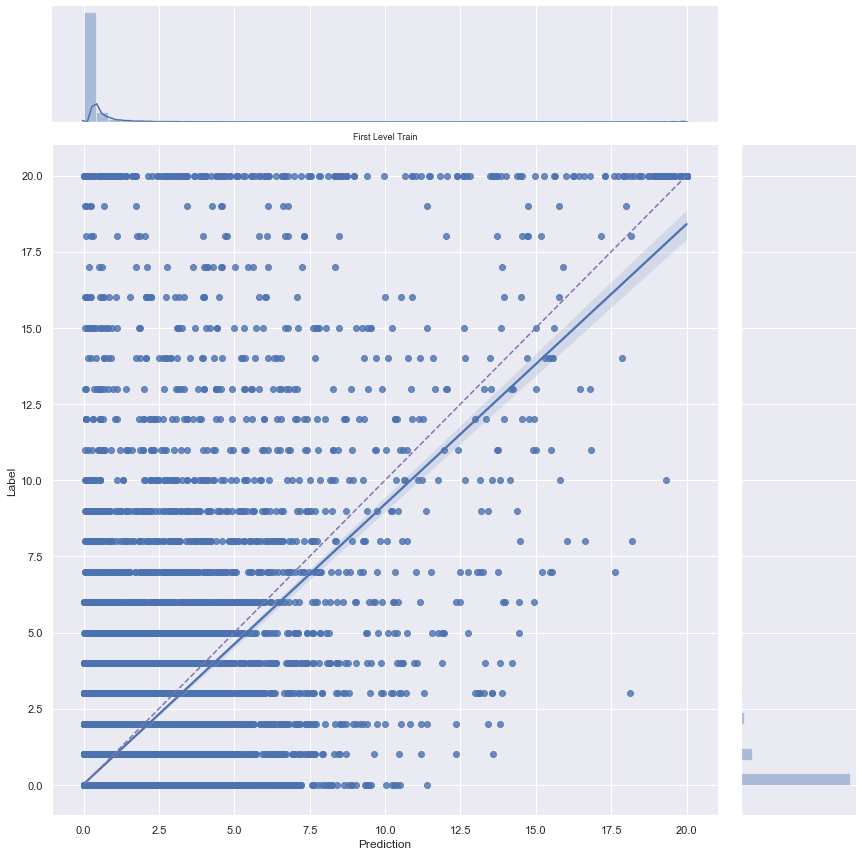

In [11]:
model_performance_sc_plot(first_level_train['0'],first_level_train['label'],'First Level Train')

In [12]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.read_csv('trees_test_matrix.csv',dtype=np.float16)
first_level_test.drop(['Unnamed: 0'], axis=1, inplace = True)
first_level_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.290283,0.386719,0.470215,0.416992,0.403564,0.506836,0.504883,0.385742,0.346436,0.481934,0.640625,0.410400
1,0.302979,0.158447,0.287109,0.406738,0.270264,0.161255,0.250488,0.407227,0.385254,0.153198,0.215332,0.406494
2,0.770508,0.760742,0.856445,0.769531,0.760742,0.874023,0.930176,0.775391,0.822266,0.886719,0.877441,0.769531
3,0.339600,0.352783,0.427002,0.345947,0.330811,0.311768,0.388428,0.353027,0.391602,0.322266,0.383789,0.346191
4,2.875000,3.458984,3.871094,2.160156,2.640625,3.361328,3.871094,2.160156,2.421875,3.560547,3.722656,2.160156


In [13]:
meta_model = LinearRegression(n_jobs=-1)

In [14]:
# Drop label from dataset and fit.
first_level_train.drop('label', axis=1, inplace=True)
meta_model.fit(first_level_train, y_valid)

LinearRegression(n_jobs=-1)

In [15]:
ensemble_pred = meta_model.predict(first_level_train)
final_predictions = meta_model.predict(first_level_test)

In [16]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, y_valid)))

Train rmse: 0.8794525


In [17]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('stacktrees_sub1.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.193054
1,1,0.425253
2,2,0.614248
3,3,0.475956
4,4,2.489328
5,5,0.183905
6,6,0.443543
7,7,0.225278
8,8,0.851571
9,9,0.907711


In [18]:
#simple convex mix, just to try
X_train_level2 = first_level_train.sample(n=2, axis=1, random_state=1).values
y_train_level2 = y_valid.values

alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = -1
r2_train_simple_mix = -1

for current_alpha in alphas_to_try:
    mix = current_alpha * X_train_level2[:,0] + (1 - current_alpha) * X_train_level2[:,1]
    current_r2 = r2_score(y_train_level2, mix)
    if(current_r2 > r2_train_simple_mix):
        r2_train_simple_mix = current_r2
        best_alpha = current_alpha


print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 1.000000; Corresponding r2 score on train: 0.369943


### (6) Use random sampled regression results (columns) from the trees for stacking (first level metamodel) -> stacktrees_sub2.csv

In [19]:
# try a randomized approach by random-6-sampling just to see...

loops=1000

eval_array=[]

meta_model=lgb.LGBMRegressor(n_jobs=4)
#meta_model=LinearRegression(n_jobs=-1)

for i in range(loops):
    print('Loop {}:'.format(str(i+1)))
    random.seed(i*4711)
    rnd=random.randint(2,6)
    rand_first_level_train = first_level_train.sample(n=rnd, axis=1, random_state=i*4711)
    rand_first_level_test = first_level_test.sample(n=rnd, axis=1, random_state=i*4711)

    meta_model.fit(rand_first_level_train, y_valid)

    rand_ensemble_pred = meta_model.predict(rand_first_level_train)
    rand_final_predictions = meta_model.predict(rand_first_level_test)
    
    t_rmse=np.sqrt(mean_squared_error(rand_ensemble_pred, y_valid))
    print('Train rmse:', t_rmse)
    eval_array.append([i, t_rmse, rand_ensemble_pred, rand_final_predictions])
    print()

Loop 1:
Train rmse: 0.8346060532685982

Loop 2:
Train rmse: 0.8657677543206167

Loop 3:
Train rmse: 0.8874522408056723

Loop 4:
Train rmse: 0.8350602910682212

Loop 5:
Train rmse: 0.828637082153945

Loop 6:
Train rmse: 0.8583852494432127

Loop 7:
Train rmse: 0.8545996860377234

Loop 8:
Train rmse: 0.8378571827876077

Loop 9:
Train rmse: 0.8363500050276323

Loop 10:
Train rmse: 0.8679670429010539

Loop 11:
Train rmse: 0.8798985861744275

Loop 12:
Train rmse: 0.8667723315076497

Loop 13:
Train rmse: 0.8575995712723183

Loop 14:
Train rmse: 0.8525757323390787

Loop 15:
Train rmse: 0.8678050251759554

Loop 16:
Train rmse: 0.8289961830669155

Loop 17:
Train rmse: 0.8364979128743224

Loop 18:
Train rmse: 0.8488886745081472

Loop 19:
Train rmse: 0.8278401356866062

Loop 20:
Train rmse: 0.863865666991162

Loop 21:
Train rmse: 0.8463495736657378

Loop 22:
Train rmse: 0.8648954765034162

Loop 23:
Train rmse: 0.8842701675634769

Loop 24:
Train rmse: 0.870320922805229

Loop 25:
Train rmse: 0.88364

Train rmse: 0.8412176651445328

Loop 200:
Train rmse: 0.8475372194391895

Loop 201:
Train rmse: 0.889783003023287

Loop 202:
Train rmse: 0.8366000789618487

Loop 203:
Train rmse: 0.8360186175904906

Loop 204:
Train rmse: 0.8915793757850901

Loop 205:
Train rmse: 0.8320761239556909

Loop 206:
Train rmse: 0.8582243397405698

Loop 207:
Train rmse: 0.8934967656713011

Loop 208:
Train rmse: 0.8243938140754624

Loop 209:
Train rmse: 0.8941612798326614

Loop 210:
Train rmse: 0.8261778584300459

Loop 211:
Train rmse: 0.8499639722936095

Loop 212:
Train rmse: 0.8364241985967809

Loop 213:
Train rmse: 0.8423739286861737

Loop 214:
Train rmse: 0.8258614588740392

Loop 215:
Train rmse: 0.8407639960397273

Loop 216:
Train rmse: 0.8331254345394825

Loop 217:
Train rmse: 0.8534407888320709

Loop 218:
Train rmse: 0.855826878755706

Loop 219:
Train rmse: 0.857309929989663

Loop 220:
Train rmse: 0.8370673800007127

Loop 221:
Train rmse: 0.8516837271699942

Loop 222:
Train rmse: 0.8874522408056723

Loop 

Train rmse: 0.8915793757850901

Loop 396:
Train rmse: 0.9028117494103646

Loop 397:
Train rmse: 0.8229685928782975

Loop 398:
Train rmse: 0.907479835644916

Loop 399:
Train rmse: 0.8836405300022058

Loop 400:
Train rmse: 0.8409831701016941

Loop 401:
Train rmse: 0.8857516909671682

Loop 402:
Train rmse: 0.8240529285129364

Loop 403:
Train rmse: 0.8255162823328461

Loop 404:
Train rmse: 0.8815636178502066

Loop 405:
Train rmse: 0.907479835644916

Loop 406:
Train rmse: 0.8303476823115866

Loop 407:
Train rmse: 0.8224715840426465

Loop 408:
Train rmse: 0.871387485673796

Loop 409:
Train rmse: 0.8455889060274242

Loop 410:
Train rmse: 0.8941612798326614

Loop 411:
Train rmse: 0.9064883311716699

Loop 412:
Train rmse: 0.8278775297811523

Loop 413:
Train rmse: 0.8195785224811486

Loop 414:
Train rmse: 0.8773536129336157

Loop 415:
Train rmse: 0.8232785232782679

Loop 416:
Train rmse: 0.8210955478583423

Loop 417:
Train rmse: 0.8579617363485639

Loop 418:
Train rmse: 0.8361716359480124

Loop 

Train rmse: 0.8494278383389318

Loop 592:
Train rmse: 0.889217153260264

Loop 593:
Train rmse: 0.8458995994201147

Loop 594:
Train rmse: 0.8456119342048792

Loop 595:
Train rmse: 0.8263491090350585

Loop 596:
Train rmse: 0.8266445903088888

Loop 597:
Train rmse: 0.8329573416611809

Loop 598:
Train rmse: 0.8450793402697191

Loop 599:
Train rmse: 0.8553313549837317

Loop 600:
Train rmse: 0.8265385858217306

Loop 601:
Train rmse: 0.8806244205218938

Loop 602:
Train rmse: 0.8841987339107696

Loop 603:
Train rmse: 0.8726441388226982

Loop 604:
Train rmse: 0.8238613880702028

Loop 605:
Train rmse: 0.8691603156713581

Loop 606:
Train rmse: 0.8196738236007625

Loop 607:
Train rmse: 0.8729404599116368

Loop 608:
Train rmse: 0.8892685962240512

Loop 609:
Train rmse: 0.8226271360572789

Loop 610:
Train rmse: 0.8244461024600506

Loop 611:
Train rmse: 0.8861202931851646

Loop 612:
Train rmse: 0.8351828562687722

Loop 613:
Train rmse: 0.8665171413051623

Loop 614:
Train rmse: 0.8197257853102053

Loo

Train rmse: 0.8806244205218938

Loop 788:
Train rmse: 0.8214087631921005

Loop 789:
Train rmse: 0.8527930245005597

Loop 790:
Train rmse: 0.8692433523374199

Loop 791:
Train rmse: 0.8426740084259331

Loop 792:
Train rmse: 0.8899999696373291

Loop 793:
Train rmse: 0.8861741853351

Loop 794:
Train rmse: 0.8423642905100968

Loop 795:
Train rmse: 0.8861741853351

Loop 796:
Train rmse: 0.8682655180551324

Loop 797:
Train rmse: 0.8252752398014924

Loop 798:
Train rmse: 0.8357316676519919

Loop 799:
Train rmse: 0.8840498790757654

Loop 800:
Train rmse: 0.896291272166423

Loop 801:
Train rmse: 0.8392067753424466

Loop 802:
Train rmse: 0.8394441606646883

Loop 803:
Train rmse: 0.8193353954929671

Loop 804:
Train rmse: 0.8501288525990441

Loop 805:
Train rmse: 0.8340830951140308

Loop 806:
Train rmse: 0.8355282287307607

Loop 807:
Train rmse: 0.8281285671301746

Loop 808:
Train rmse: 0.8327896435119717

Loop 809:
Train rmse: 0.8836405300022058

Loop 810:
Train rmse: 0.8409180967121452

Loop 811:

Train rmse: 0.8815636178502066

Loop 984:
Train rmse: 0.8484252852317345

Loop 985:
Train rmse: 0.8464256908091724

Loop 986:
Train rmse: 0.8302479902838072

Loop 987:
Train rmse: 0.8525833063650116

Loop 988:
Train rmse: 0.825913920701117

Loop 989:
Train rmse: 0.8282569413956612

Loop 990:
Train rmse: 0.8227406587771963

Loop 991:
Train rmse: 0.8358065629587271

Loop 992:
Train rmse: 0.8212311826366651

Loop 993:
Train rmse: 0.8522440433620327

Loop 994:
Train rmse: 0.846552262711716

Loop 995:
Train rmse: 0.8466872686481359

Loop 996:
Train rmse: 0.8599659164299445

Loop 997:
Train rmse: 0.8382922300592504

Loop 998:
Train rmse: 0.8483561249806141

Loop 999:
Train rmse: 0.862501599277681

Loop 1000:
Train rmse: 0.8866402375624725



In [20]:
eval_array_df=pd.DataFrame(eval_array, columns=['idx', 'test_rmse', 'rand_ensemble_pred', 'rand_final_predictions'])
sorted_df = eval_array_df.sort_values(by='test_rmse', ascending=True).reset_index(drop=True)
best_pred = pd.DataFrame(sorted_df.iloc[0,3])
sorted_df.head()

,idx,test_rmse,rand_ensemble_pred,rand_final_predictions
0,369,0.815519,"[0.02977071601615897, 0.900770630674143, 0.649...","[0.6148131418705299, 0.2791732998985951, 0.822..."
1,818,0.816584,"[0.03087788826073475, 0.8996135016807635, 0.65...","[0.7313631045496204, 0.3286489103356331, 0.807..."
2,168,0.817702,"[0.029195252866688594, 0.9112971250935309, 0.6...","[0.4965801195216793, 0.31525065910567623, 0.80..."
3,946,0.818634,"[0.029715422126790788, 0.9059798466076685, 0.6...","[0.35966468706917415, 0.2250534163345129, 0.82..."
4,109,0.818661,"[0.0290613380532553, 0.9069149470639063, 0.662...","[0.38216436660253883, 0.22865992915806654, 0.8..."


In [21]:
best_pred.head()

,0
0,0.614813
1,0.279173
2,0.822084
3,0.442823
4,3.086123


In [22]:
rand_prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
rand_prediction_df['item_cnt_month'] = best_pred.clip(0., 20.)
rand_prediction_df.to_csv('stacktrees_sub2.csv', index=False)
rand_prediction_df.head(10)

,ID,item_cnt_month
0,0,0.614813
1,1,0.279173
2,2,0.822084
3,3,0.442823
4,4,3.086123
5,5,0.337852
6,6,0.563166
7,7,0.157834
8,8,0.900771
9,9,0.571099
